In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from tqdm import trange

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t2 import CorticalColumn, LayerConnection, ComplexStructure, load, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection, get_output_size_maxpool1d

In [2]:
seed = random.randint(0,9999999)
print(seed)

670071


In [3]:
# seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

# Load Model

In [4]:
model = load('models/c3.pt')
model.disable_learning()

In [5]:
network = Network(dt=1.0)
model.add_to_network(network)

# Check C1 --> C3 Acitvity

In [6]:
input_size_c1 = 200
input_size_c2 = 200
each_session = 40
session_number = 10
gap_time = 20

time = session_number * each_session
spike_train_c1 = torch.zeros(time, input_size_c1).bool()
spike_train_c2 = torch.zeros(time, input_size_c2).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
active_fire_rate = 0.2

pattern_size = int(input_size_c1/2)
for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size_c1) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train_c1[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train_c1[idx * each_session: (idx + 1) * each_session, :int(input_size_c1/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train_c1[idx * each_session: (idx + 1) * each_session, int(input_size_c1/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls
   
pattern_size = int(input_size_c2/2)
for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size_c2) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train_c2[idx * each_session: (idx + 1) * each_session, :] = passive_noise

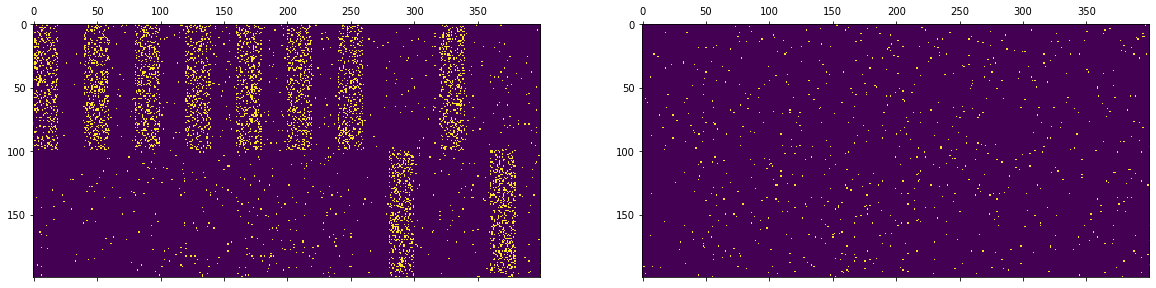

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 28))
axs[0].matshow(spike_train_c1.T[:, :])
axs[1].matshow(spike_train_c2.T[:, :])

In [8]:
for part in trange(session_number, unit="parts"):
    inp = {
        'input_c1': spike_train_c1[part*each_session:part*each_session+each_session, :],
        'input_c2': spike_train_c2[part*each_session:part*each_session+each_session, :],
    }
    network.run(inputs=inp, time=each_session)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.12parts/s]


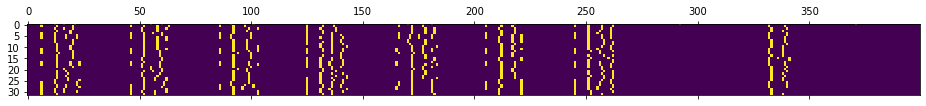

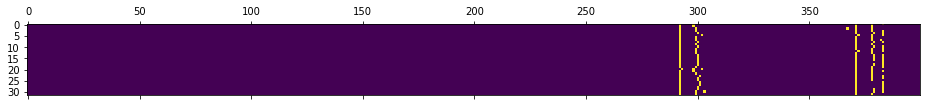

In [9]:
for name, monitor in model.submodules[2].l23.monitors:
    spikes = monitor.get('s').T[:, 0, :]
    plt.matshow(spikes)

In [10]:
model.monitors_reset_state_variables()

# Check C2 --> C3 Acitvity

In [11]:
input_size_c1 = 200
input_size_c2 = 200
each_session = 40
session_number = 10
gap_time = 20

time = session_number * each_session
spike_train_c1 = torch.zeros(time, input_size_c1).bool()
spike_train_c2 = torch.zeros(time, input_size_c2).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
active_fire_rate = 0.2

pattern_size = int(input_size_c1/2)
for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size_c1) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train_c1[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    
pattern_size = int(input_size_c2/2)
for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size_c2) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train_c2[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train_c2[idx * each_session: (idx + 1) * each_session, :int(input_size_c2/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train_c2[idx * each_session: (idx + 1) * each_session, int(input_size_c2/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

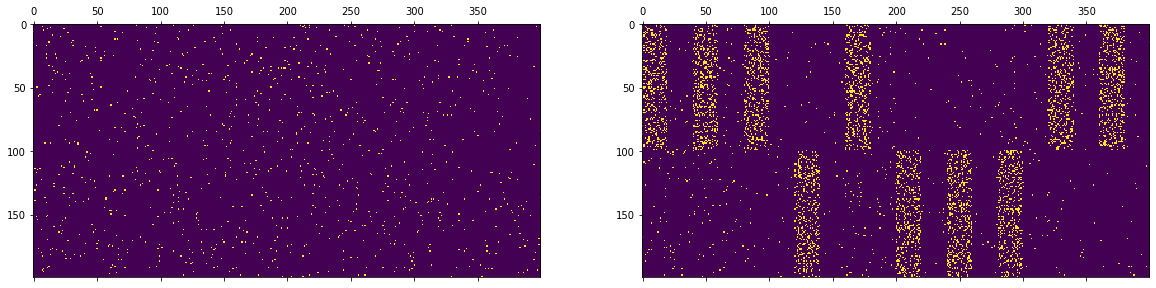

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 28))
axs[0].matshow(spike_train_c1.T[:, :])
axs[1].matshow(spike_train_c2.T[:, :])

In [13]:
for part in trange(session_number, unit="parts"):
    inp = {
        'input_c1': spike_train_c1[part*each_session:part*each_session+each_session, :],
        'input_c2': spike_train_c2[part*each_session:part*each_session+each_session, :],
    }
    network.run(inputs=inp, time=each_session)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.10parts/s]


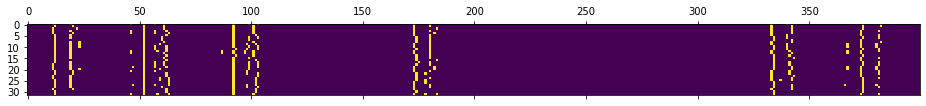

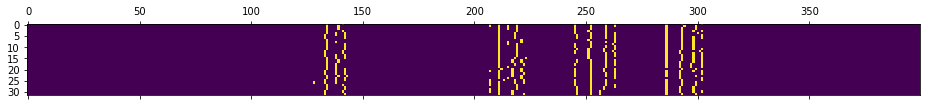

In [14]:
for name, monitor in model.submodules[2].l23.monitors:
    spikes = monitor.get('s').T[:, 0, :]
    plt.matshow(spikes)

In [15]:
model.monitors_reset_state_variables()